In [55]:
#Importing libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the "../input/" directory.
import os
import matplotlib.pyplot as plt#visualization
from PIL import  Image
%matplotlib inline
import pandas as pd
import seaborn as sns#visualization
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [56]:
train = pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [57]:
train.drop('Id',axis=1,inplace=True)
test.drop('Id',axis=1,inplace=True)

In [58]:
train_n=train[[c for c in train.columns if train[c].dtypes!='O']].copy()
test_n=test[[c for c in test.columns if test[c].dtypes!='O']].copy()

train_c=train[[c for c in train.columns if train[c].dtypes=='O']].copy()
test_c=test[[c for c in test.columns if test[c].dtypes=='O']].copy()

In [59]:
test_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 36 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   int64  
 1   LotFrontage    1232 non-null   float64
 2   LotArea        1459 non-null   int64  
 3   OverallQual    1459 non-null   int64  
 4   OverallCond    1459 non-null   int64  
 5   YearBuilt      1459 non-null   int64  
 6   YearRemodAdd   1459 non-null   int64  
 7   MasVnrArea     1444 non-null   float64
 8   BsmtFinSF1     1458 non-null   float64
 9   BsmtFinSF2     1458 non-null   float64
 10  BsmtUnfSF      1458 non-null   float64
 11  TotalBsmtSF    1458 non-null   float64
 12  1stFlrSF       1459 non-null   int64  
 13  2ndFlrSF       1459 non-null   int64  
 14  LowQualFinSF   1459 non-null   int64  
 15  GrLivArea      1459 non-null   int64  
 16  BsmtFullBath   1457 non-null   float64
 17  BsmtHalfBath   1457 non-null   float64
 18  FullBath

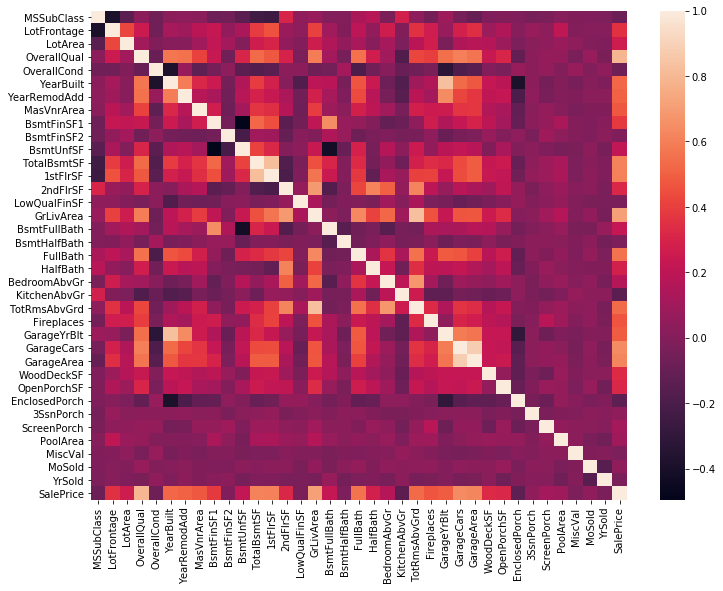

In [60]:
#EDA on numeric fields 
#correlation
correlation = train_n.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(correlation);

In [61]:
corr_set = correlation.stack()
corr_final=corr_set[corr_set > 0.8]
corr_final[corr_final !=1]
#the pair which are highly colinear are below

YearBuilt     GarageYrBlt     0.825667
TotalBsmtSF   1stFlrSF        0.819530
1stFlrSF      TotalBsmtSF     0.819530
GrLivArea     TotRmsAbvGrd    0.825489
TotRmsAbvGrd  GrLivArea       0.825489
GarageYrBlt   YearBuilt       0.825667
GarageCars    GarageArea      0.882475
GarageArea    GarageCars      0.882475
dtype: float64

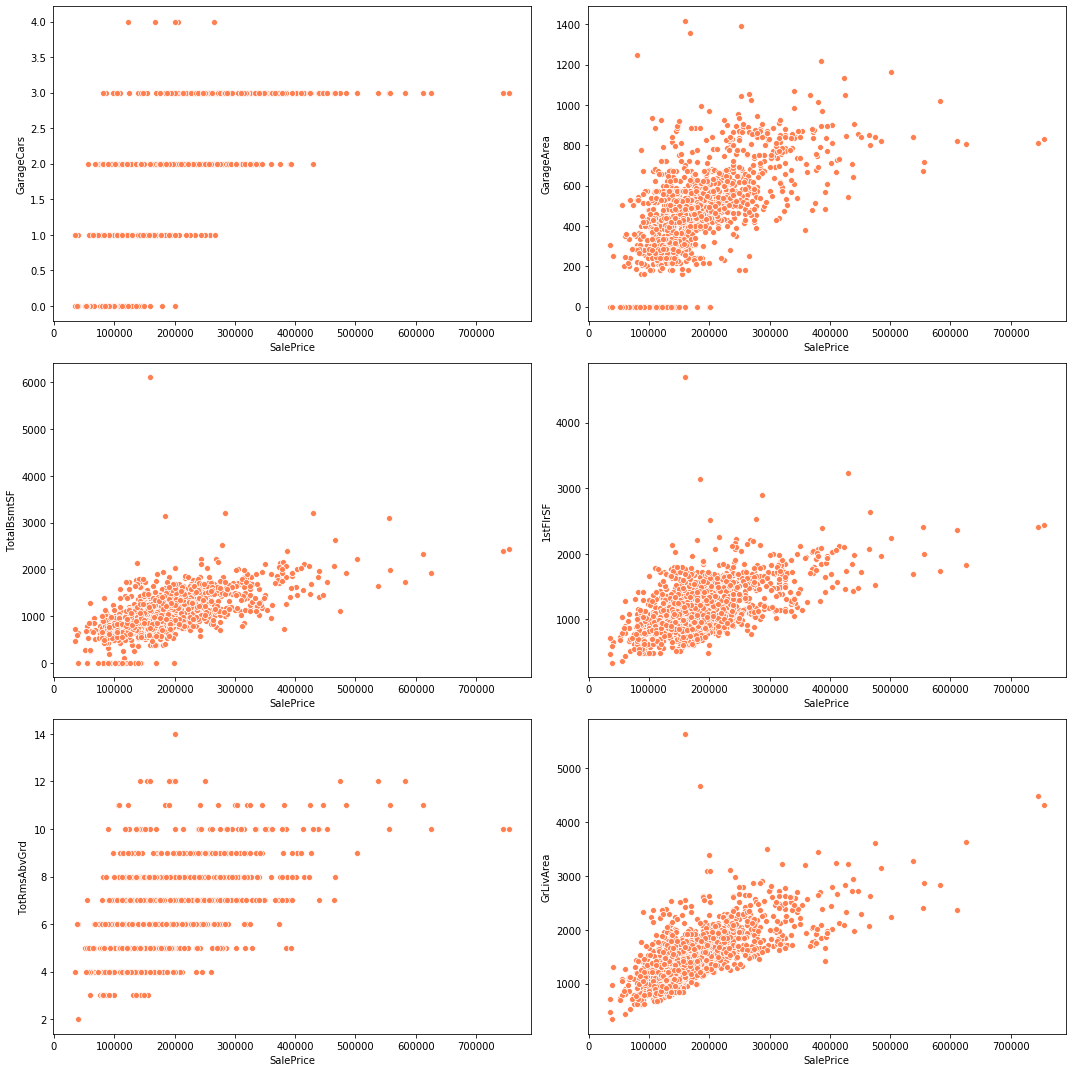

In [62]:
#using the plots below we can decide which variable can be chpsen to be eliminated 
fig,ax=plt.subplots(3,2,figsize=(15,15))
sns.scatterplot(train_n['SalePrice'],train_n['GarageCars'],ax=ax[0][0],color='coral')
sns.scatterplot(train_n['SalePrice'],train_n['GarageArea'],ax=ax[0][1],color='coral')
sns.scatterplot(train_n['SalePrice'],train_n['TotalBsmtSF'],ax=ax[1][0],color='coral')
sns.scatterplot(train_n['SalePrice'],train_n['1stFlrSF'],ax=ax[1][1],color='coral')
sns.scatterplot(train_n['SalePrice'],train_n['TotRmsAbvGrd'],ax=ax[2][0],color='coral')
sns.scatterplot(train_n['SalePrice'],train_n['GrLivArea'],ax=ax[2][1],color='coral')
fig.tight_layout()
#GarageCars,TotRmsAbvGrd,1stFlrSF are chosen

In [74]:
#Remove the corelated variables from the dataset
train_n1=train_n.drop(['GarageCars','1stFlrSF','TotRmsAbvGrd'],axis=1)
test_n1=test_n.drop(['GarageCars','1stFlrSF','TotRmsAbvGrd'],axis=1)

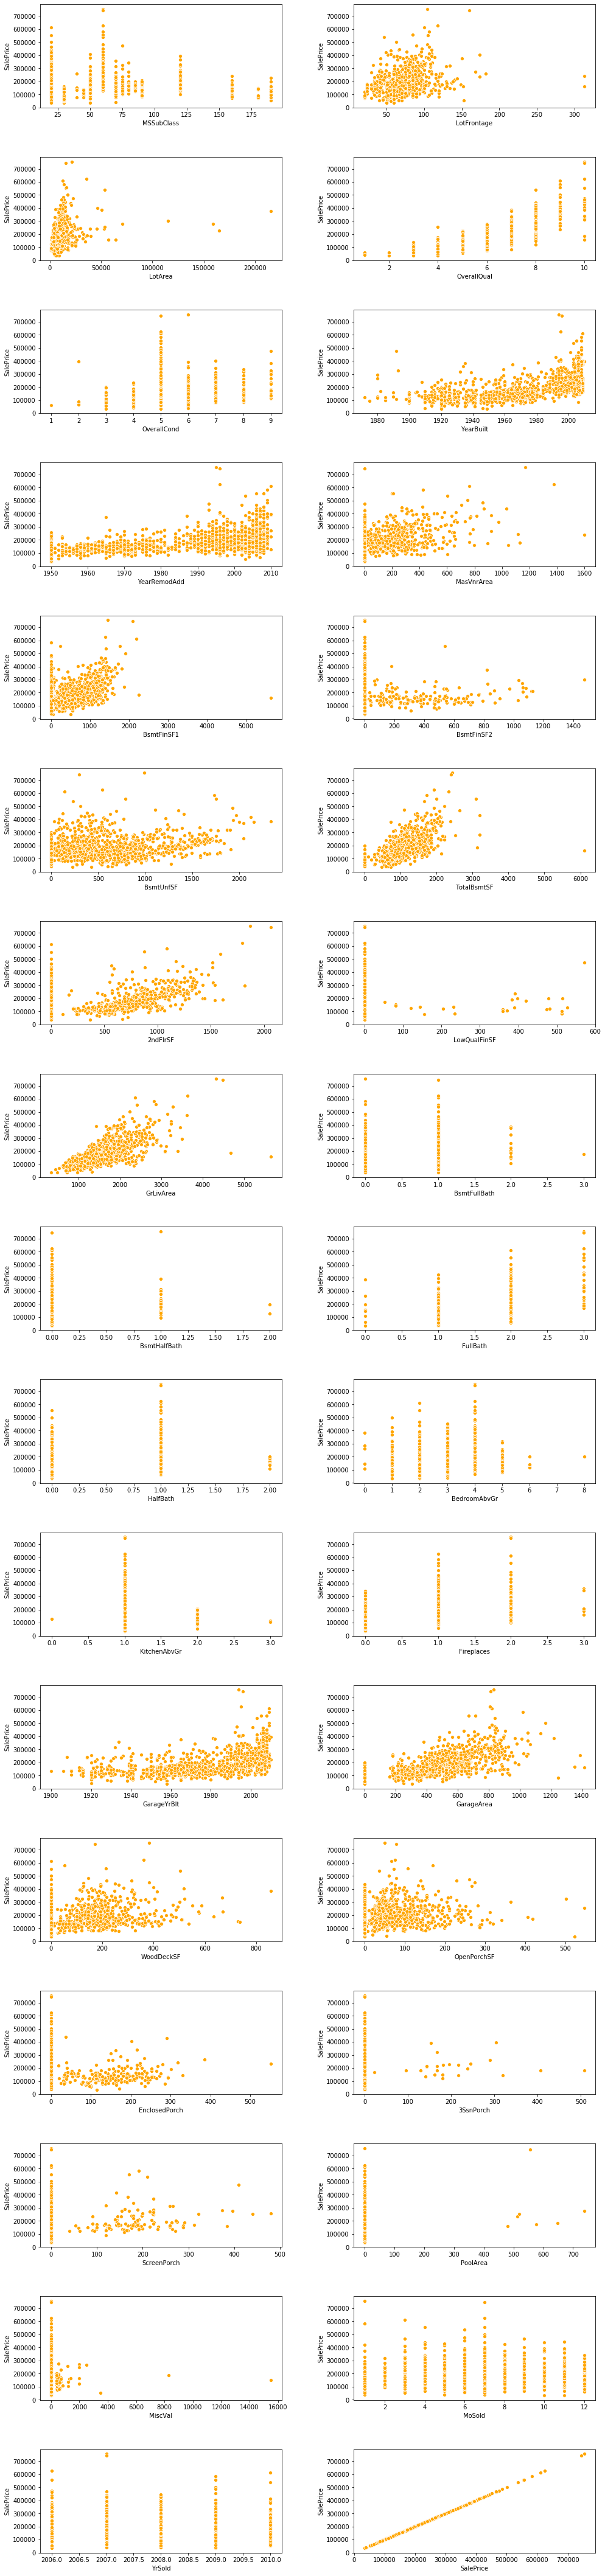

In [75]:
# Feature examination and removing non linear feature 
fig,ax=plt.subplots(17,2,figsize=(15,60))
def graph(x,y,r,c,title):
    sns.scatterplot(train_n1[x],y,color=('orange'),ax=ax[r][c])
    ax[r][c].set_xlabel(x)
    fig.tight_layout(pad=5.0)

for r,col in enumerate(train_n1.columns):
    c=r%2
    graph(col,train['SalePrice'],r//2,c,col)

In [76]:
#Remove non linear variables based on above scatter plots
non_linear=['MSSubClass','LotArea','OverallCond','LowQualFinSF','BsmtFullBath', 'BsmtHalfBath','FullBath', 'HalfBath','BedroomAbvGr',
            'KitchenAbvGr','Fireplaces','3SsnPorch','ScreenPorch' ,'PoolArea','MiscVal','MoSold', 'YrSold']
print("total non-linear",len(non_linear)," columns")

total non-linear 17  columns


In [77]:
#We have removed  non-linear features from the dataset
linear_features=np.array([col for col in train_n1.columns if col not in non_linear])

In [78]:
linear_features

array(['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '2ndFlrSF', 'GrLivArea', 'GarageYrBlt',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       'SalePrice'], dtype='<U13')

In [79]:
#Missing Values in train for numerical fields
Missingval_n=train_n1.columns[train_n1.isna().any()].tolist()
pd.DataFrame(train_n1,columns=Missingval_n).isna().sum()

LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64

In [80]:
#Missing Values in test for numerical fields
Missingval_n=test_n1.columns[test_n1.isna().any()].tolist()
pd.DataFrame(test_n1,columns=Missingval_n).isna().sum()

LotFrontage     227
MasVnrArea       15
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
GarageYrBlt      78
GarageArea        1
dtype: int64

In [81]:
#Data Imputation on the numeric fields 

train_n1['GarageYrBlt']=train_n1['GarageYrBlt'].fillna(train_n1['GarageYrBlt'].median())
test_n1['GarageYrBlt']=test_n1['GarageYrBlt'].fillna(test_n1['GarageYrBlt'].median())

for col in train_n1.columns:
    train_n1[col] = train_n1[col].fillna(0)
for col in test_n1.columns:
    test_n1[col] = test_n1[col].fillna(0)

In [82]:
print(train_n1[linear_features].shape)
print(test_n1[linear_features[:-1]].shape)

(1460, 17)
(1459, 16)


In [83]:
train_n1.isnull().sum()[train_n1.isnull().sum()!=0]

Series([], dtype: int64)

In [84]:
test_n1.isnull().sum()[test_n1.isnull().sum()!=0]

Series([], dtype: int64)

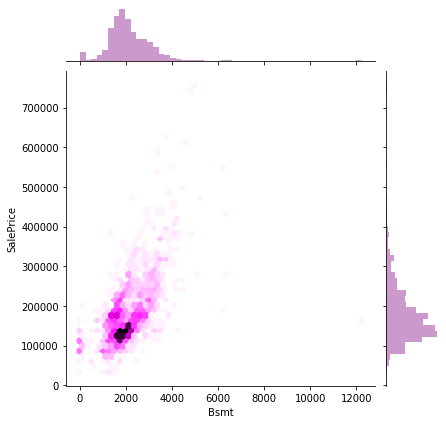

In [85]:
train_n1['Bsmt']=train_n1['BsmtFinSF1']+train_n1['BsmtFinSF2']+train_n1['BsmtUnfSF']+train_n1['TotalBsmtSF']
test_n1['Bsmt']=test_n1['BsmtFinSF1']+test_n1['BsmtFinSF2']+test_n1['BsmtUnfSF']+test_n1['TotalBsmtSF']
sns.jointplot(train_n1['Bsmt'],train_n1['SalePrice'],kind='hex',color='purple')

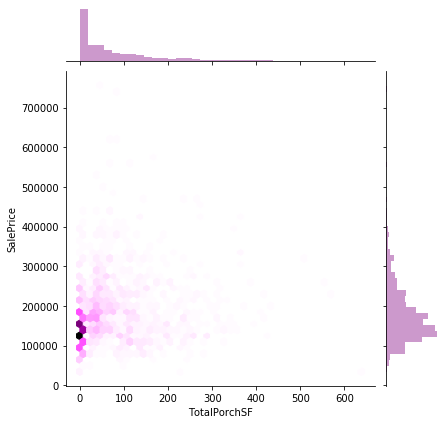

In [86]:
train_n1['TotalPorchSF']=train_n1['EnclosedPorch']+train_n1['OpenPorchSF']
test_n1['TotalPorchSF']=test_n1['EnclosedPorch']+test_n1['OpenPorchSF']
sns.jointplot(train_n1['TotalPorchSF'],train_n1['SalePrice'],kind='hex',color='purple')

In [87]:
linear_features

array(['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '2ndFlrSF', 'GrLivArea', 'GarageYrBlt',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       'SalePrice'], dtype='<U13')

In [88]:
linear_features=['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea','Bsmt', '2ndFlrSF', 'GrLivArea', 'GarageYrBlt',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch']

In [89]:
train_n1[linear_features].columns

Index(['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'Bsmt', '2ndFlrSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch'],
      dtype='object')

In [90]:
test_n1[linear_features].columns

Index(['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'Bsmt', '2ndFlrSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch'],
      dtype='object')

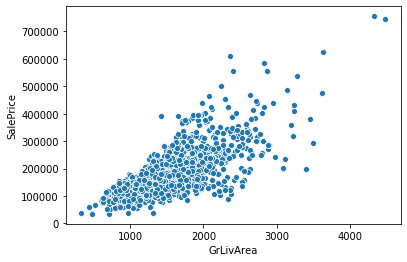

In [91]:
#Remove outliers manually in train
#removing the outliers greater than 4600
train_n1=train_n1[train_n1['GrLivArea']<4600]
train_n1.reset_index(drop = True, inplace = True)
sns.scatterplot(x='GrLivArea',y='SalePrice',data=train_n1)

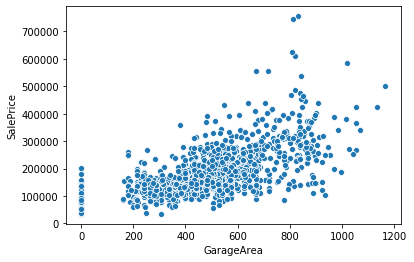

In [92]:
#removing the outliers greater than 1200
train_n1=train_n1[train_n1['GarageArea']<1200]
train_n1.reset_index(drop = True, inplace = True)
sns.scatterplot(x='GarageArea',y='SalePrice',data=train_n1)

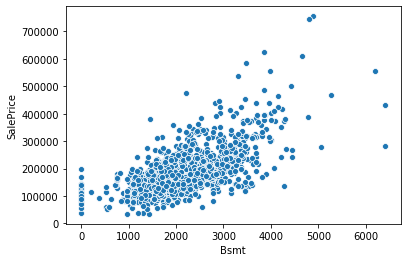

In [93]:
#removing the outliers greater than 12000
train_n1=train_n1[train_n1['Bsmt']< 12000]
train_n1.reset_index(drop = True, inplace = True)
sns.scatterplot(x='Bsmt',y='SalePrice',data=train_n1)

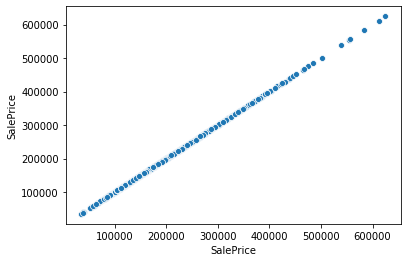

In [94]:
#removing the outliers greater than 700000
train_n1=train_n1[train_n1['SalePrice']<700000]
train_n1.reset_index(drop = True, inplace = True)
sns.scatterplot(x='SalePrice',y='SalePrice',data=train_n1)

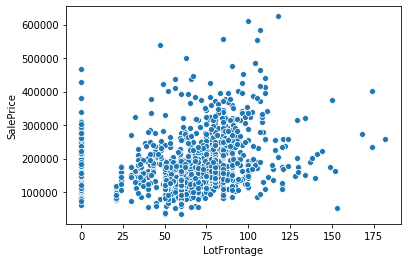

In [95]:
#removing the outliers greater than 300
train_n1=train_n1[train_n1['LotFrontage']<300]
train_n1.reset_index(drop = True, inplace = True)
sns.scatterplot(x='LotFrontage',y='SalePrice',data=train_n1)

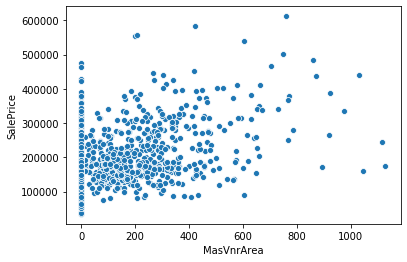

In [96]:
#removing the outliers greater than 1200
train_n1=train_n1[train_n1['MasVnrArea']<1200]
train_n1.reset_index(drop = True, inplace = True)
sns.scatterplot(x='MasVnrArea',y='SalePrice',data=train_n1)

In [97]:
print(train_n1.shape)
print(train_n1[linear_features].shape)

(1449, 36)
(1449, 13)


In [98]:
#Check the skewness
Train_X_n=train_n1[linear_features]
Train_Y_n=train_n1['SalePrice']

In [99]:
Train_X_n.skew()

LotFrontage     -0.307511
OverallQual      0.173680
YearBuilt       -0.609847
YearRemodAdd    -0.497440
MasVnrArea       2.297075
Bsmt             0.480224
2ndFlrSF         0.764205
GrLivArea        0.813368
GarageYrBlt     -0.672542
GarageArea      -0.004658
WoodDeckSF       1.556730
OpenPorchSF      2.337115
EnclosedPorch    3.074949
dtype: float64

In [100]:
Train_Y_n.skew()

1.5032207208089576

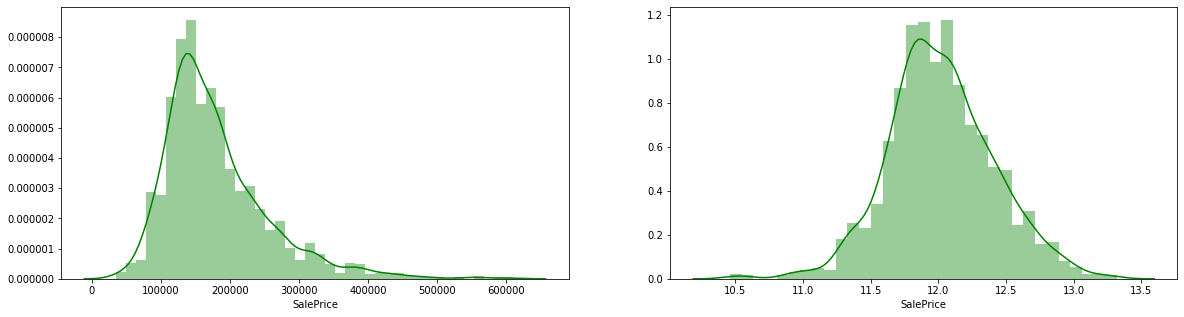

In [101]:
fig,ax=plt.subplots(1,2,figsize=(20,5))
sns.distplot(Train_Y_n,ax=ax[0],color='green')
sns.distplot(np.log1p(Train_Y_n),ax=ax[1],color='green')
# fig.tight_layout()

In [102]:
train_c=train[[c for c in train.columns if train[c].dtypes=='O']].copy()
test_c=test[[c for c in test.columns if test[c].dtypes=='O']].copy()

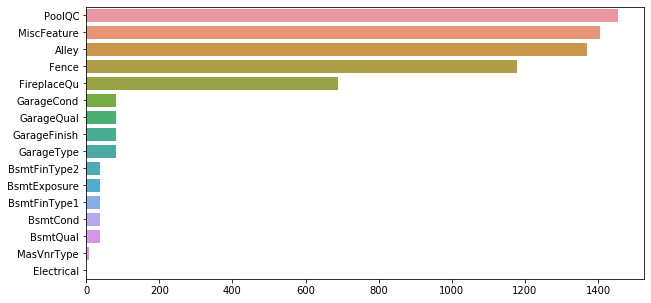

In [103]:
# print(train_c.shape)
fig=plt.figure(figsize=(10,5))
train_null=train_c.isnull().sum()[train_c.isnull().sum()!=0].sort_values(ascending=False)
sns.barplot(y=train_null.index,x=train_null)

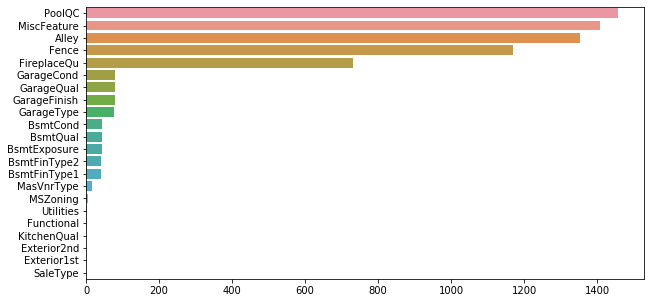

In [104]:
fig=plt.figure(figsize=(10,5))
test_null=test_c.isnull().sum()[test_c.isnull().sum()!=0].sort_values(ascending=False)
sns.barplot(y=test_null.index,x=test_null)

In [105]:
#Dropping the first 5 columns in both test and train 
train_c.dropna(thresh=len(train_c)*0.9,axis=1,inplace=True)

In [106]:
test_c.dropna(thresh=len(test_c)*0.9,axis=1,inplace=True)

In [107]:
#Forward fiull the categorical variables which has missing values 
train_c['Electrical']=train_c['Electrical'].fillna(method='ffill')
test_c['SaleType']=test_c['SaleType'].fillna(method='ffill')
test_c['KitchenQual']=test_c['KitchenQual'].fillna(method='ffill')
test_c['Exterior1st']=test_c['Exterior1st'].fillna(method='ffill')
test_c['Exterior2nd']=test_c['Exterior2nd'].fillna(method='ffill')
test_c['Functional']=test_c['Functional'].fillna(method='ffill')
test_c['Utilities']=test_c['Utilities'].fillna(method='ffill')
test_c['MSZoning']=test_c['MSZoning'].fillna(method='ffill')

In [108]:
#check for Categorical missing values
for col in train_c.columns:
    train_c[col] = train_c[col].fillna("None")
for col in test_c.columns:
    test_c[col] = test_c[col].fillna("None")

In [109]:
print("Train null values : ",len(train_c.isnull().sum()[train_c.isnull().sum()!=0]))
print("Test null values : ",len(test_c.isnull().sum()[test_c.isnull().sum()!=0]))

Train null values :  0
Test null values :  0


In [110]:
#Label encoding
train_c_labeled=pd.DataFrame()
test_c_labeled=pd.DataFrame()

for col in train_c.columns:
    le = preprocessing.LabelEncoder()
    train_c_labeled[col]=le.fit_transform(train_c[col])
    test_c_labeled[col]=le.fit_transform(test_c[col])

In [111]:
test_c_labeled

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,2,1,3,3,0,4,0,12,1,2,...,3,3,6,1,3,4,5,2,8,4
1,3,1,0,3,0,0,0,12,2,2,...,3,2,6,1,3,4,5,2,8,4
2,3,1,0,3,0,4,0,8,2,2,...,3,3,6,1,0,4,5,2,8,4
3,3,1,0,3,0,4,0,8,2,2,...,3,2,6,1,0,4,5,2,8,4
4,3,1,0,1,0,4,0,22,2,2,...,3,2,6,1,2,4,5,2,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,4,1,3,3,0,4,0,10,2,2,...,3,3,6,6,1,2,3,2,8,4
1455,4,1,3,3,0,4,0,10,2,2,...,3,3,6,4,3,4,5,2,8,0
1456,3,1,3,3,0,4,0,11,2,2,...,3,3,6,5,3,4,5,2,8,0
1457,3,1,3,3,0,4,0,11,2,2,...,3,3,6,6,1,2,3,2,8,4


In [112]:
#Merging numerical and categorical data
final_train=train_n1.merge(train_c_labeled,left_index=True,right_index=True).reset_index(drop=True)
final_test=test_n1.merge(test_c_labeled,left_index=True,right_index=True).reset_index(drop=True)

In [113]:
final_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 74 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1449 non-null   int64  
 1   LotFrontage    1449 non-null   float64
 2   LotArea        1449 non-null   int64  
 3   OverallQual    1449 non-null   int64  
 4   OverallCond    1449 non-null   int64  
 5   YearBuilt      1449 non-null   int64  
 6   YearRemodAdd   1449 non-null   int64  
 7   MasVnrArea     1449 non-null   float64
 8   BsmtFinSF1     1449 non-null   int64  
 9   BsmtFinSF2     1449 non-null   int64  
 10  BsmtUnfSF      1449 non-null   int64  
 11  TotalBsmtSF    1449 non-null   int64  
 12  2ndFlrSF       1449 non-null   int64  
 13  LowQualFinSF   1449 non-null   int64  
 14  GrLivArea      1449 non-null   int64  
 15  BsmtFullBath   1449 non-null   int64  
 16  BsmtHalfBath   1449 non-null   int64  
 17  FullBath       1449 non-null   int64  
 18  HalfBath

In [114]:
#Divide into training data and testing data
y=final_train['SalePrice']
x=final_train.drop('SalePrice',axis=1)
#Splitting training and testing data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.90,test_size=0.10, random_state=0)



In [115]:
#Modelling 
#Linear Regression
#Linear Regression
linearRegressor = LinearRegression()
linearRegressor.fit(x_train, y_train)
y_predicted = linearRegressor.predict(x_test)
mse = mean_squared_error(y_test, y_predicted)
r = r2_score(y_test, y_predicted)
mae = mean_absolute_error(y_test,y_predicted)
print("Mean Squared Error:",mse)
print("R score:",r)
print("Mean Absolute Error:",mae)

Mean Squared Error: 1191658833.4453344
R score: 0.7965280755148825
Mean Absolute Error: 23701.77945138329


In [116]:
##Now we fit the ml model to the test data to make the prediction
#Linear Regression
linearRegressor = LinearRegression()
linearRegressor.fit(x, y)
y_predicted = linearRegressor.predict(x_test)
predictionlist=y_predicted.tolist()

In [118]:
predictionlist

[290962.96016270434,
 190495.42397210316,
 203072.68701542856,
 260509.64726510854,
 328832.67215712846,
 249975.9194582228,
 226344.67787350982,
 172436.88587049965,
 279555.9324861936,
 148204.48382248252,
 210806.60290833772,
 132129.27944267116,
 247232.933355103,
 325969.24516046164,
 275519.5959838163,
 140918.6240416998,
 181420.0675745568,
 125697.01978284237,
 215822.98567060637,
 213946.08386340784,
 186770.63722306595,
 124430.58799107879,
 161492.38500165066,
 138721.94948376354,
 270960.17266342824,
 220938.01500945154,
 285153.45059299737,
 113821.49134509737,
 101424.23601912556,
 294792.4782438418,
 170675.24136552087,
 192053.0029355298,
 123385.33913082478,
 376233.025533417,
 119261.77019279776,
 205183.7917957293,
 148176.38399607572,
 126924.10941133986,
 139726.62031306897,
 111423.8426229966,
 122691.1323568754,
 207992.30674031097,
 98228.68573995691,
 107012.34427919437,
 151699.14411552576,
 191378.74292349815,
 67108.71687415341,
 288259.1578550682,
 218842.6